In [25]:
import json
import math
import pickle

import matplotlib.pyplot as plt
import networkx as nx

In [26]:
dataset_path = "../datasets/UrbanVehicle"

## Create road graph as networkx DiGraph
road_graph = nx.DiGraph()
with open(f"{dataset_path}/map.json", mode="r", encoding="utf-8") as file:
    items = json.load(file)

    for item in items:
        if item["type"] == "node":
            road_graph.add_node(item["id"], pos=(item["xy"][0], item["xy"][1]))

    edge_id = 0
    for item in items:
        if item["type"] == "way":
            nodes = item["nodes"]
            is_oneway = item["oneway"]

            for u, v in zip(nodes, nodes[1:]):
                road_graph.add_edge(u, v, id=edge_id)
                edge_id += 1
                if not is_oneway:
                    road_graph.add_edge(v, u, id=edge_id)
                    edge_id += 1

# Remove self-loops from road graph
# Nodes with self-loops: 64, 74, 192, 193, 198, 255, 262, 272, 277, 442, 448, 505, 595, 653, 829, 872, 1035, 1052, 1054, 1055, 1150
road_graph.remove_edges_from(nx.selfloop_edges(road_graph))

# Add euclidean distances to edges of road graph
for u, v in road_graph.edges():
    u_x, u_y = road_graph.nodes[u]["pos"]
    v_x, v_y = road_graph.nodes[v]["pos"]
    distance = math.sqrt((v_x - u_x) ** 2 + (v_y - u_y) ** 2)
    road_graph.edges[u, v]["weight"] = distance

# Save road graph
with open("road_graph_nsl.pickle", mode="wb") as file:
    pickle.dump(road_graph, file)

# (Optional) Consolidate intersections and simplify graph

print(road_graph)

# Check connectivity
# Non-connected nodes: 2336, 6817, 2341, 2247, 1512, 2248, 5289, 2795, 2796, 1520, 7857, 2262, 7448, 2333
# Non-connected edges: 9344, 10424
print("Road graph is strongly connected: ", nx.is_strongly_connected(road_graph))
print("Road graph is weakly connected: ", nx.is_weakly_connected(road_graph))

DiGraph with 8270 nodes and 10186 edges
Road graph is strongly connected:  False
Road graph is weakly connected:  False


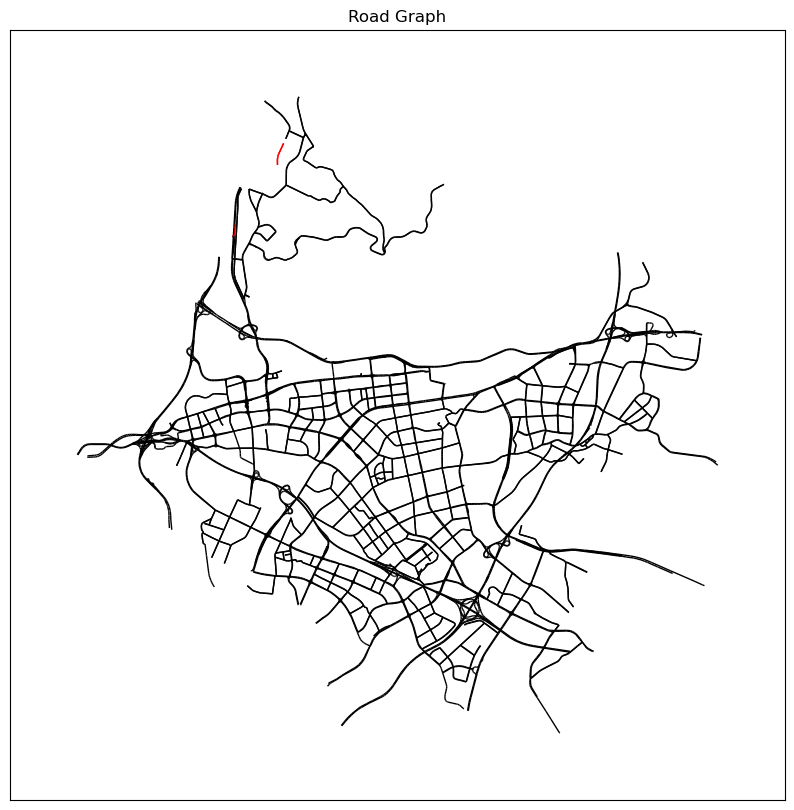

In [27]:
# Find maximum weakly-connected sub road graph
wccs = list(nx.weakly_connected_components(road_graph))
max_wcc = max(wccs, key=len)
max_wcc_sub_road_graph = road_graph.subgraph(max_wcc).copy()

# Save weakly-connected sub road graph
with open("road_graph_nsl_wc.pickle", mode="wb") as file:
    pickle.dump(max_wcc_sub_road_graph, file)

## Draw the road graph
pos = nx.get_node_attributes(road_graph, "pos")

# Find sub road graph consisting of weakly-connected components that are not the maximum one
left_out_nodes = set(road_graph.nodes()) - set(max_wcc_sub_road_graph.nodes())
left_out_sub_road_graph = road_graph.subgraph(left_out_nodes)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# nx.draw_networkx(
#     road_graph,
#     pos,
#     with_labels=False,
#     arrows=False,
#     edge_color="black",
#     node_size=1,
#     node_color="blue",
#     ax=ax
# )
#
# # node_ids = [105, 741, 90, 732, 567, 580, 924, 6099, 59, 601, 1351, 133]
# # other_node_ids = [6091, 3891, 3815, 4582, 3890, 3808, 3809, 10529, 6927, 4237, 3835, 4218]
# #
# # for node in road_graph.nodes():
# #     if node in node_ids:
# #         x, y = pos[node]
# #         ax.text(x, y, str(node), fontsize=1, color="red", ha="center", va="center")

# nx.draw_networkx_nodes(
#     max_wcc_sub_road_graph,
#     pos,
#     node_size=1,
#     ax=ax
# )
# nx.draw_networkx_nodes(
#     left_out_sub_road_graph,
#     pos,
#     node_color="red",
#     node_size=10,
#     ax=ax
# )
nx.draw_networkx_edges(
    max_wcc_sub_road_graph,
    pos,
    arrows=False,
    ax=ax
)
nx.draw_networkx_edges(
    left_out_sub_road_graph,
    pos,
    edge_color="red",
    arrows=False,
    ax=ax
)
ax.set_title("Road Graph")

# plt.savefig("road_graph.svg")
plt.show()